# Data Wrangling 

Data wrangling: (combining previous weeks' results and add some more features)
    1. remove duplicate rows
    2. add last day's volumn, open interest rate, closing price for each option 
    3. add last week's volumn, open interest rate, closing price for each option
    4. add last day's sp500 price and last week's price 
    5. select options whose today's sp500 price is within 30 of strike price 
    5. remove rows with null values
    6. group all the options corresponding to their (settlement date, today's date) and pick all the interested features

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

In [2]:
def readToDataFrame(input):
    """ read data from input path and return dataframe where settle date and todaydate is transfferd to datetime format
    """
    optiondata = pd.read_table( input, delimiter = ",")
    todaydate_tmp = [pd.datetime.strptime(str(x), '%Y%m%d') for x in optiondata.todaydate]
    optiondata.todaydate = todaydate_tmp
    settledate_tmp = [pd.datetime.strptime(str(x), '%Y%m%d') for x in optiondata.settledate]
    optiondata.settledate = settledate_tmp
    return optiondata.drop_duplicates()
optiondata = readToDataFrame("relevantoptions2")

In [3]:
# create dictionary to store everyday's sp500 price

def createPriceDict(row, pricedict):
    if not pricedict.has_key(row['todaydate']):
        pricedict[row['todaydate'].strftime("%B %d, %Y")] = row['today_sp_price']

def getPrice(df):
    """get vol and sp500 today price for each day
    """
    price = {}
    df.apply(lambda row: createPriceDict(row, price), axis=1)
    return price

priceDict = getPrice(optiondata)

In [4]:
# create dictionary to store every option's volumn, open interest rate, closing price 
def createOptionDict(row, optdict):
    if not optdict.has_key((row['todaydate'],row['settledate'],row['optiontype'],row['optionstrike'])):
        optdict[(row['todaydate'],row['settledate'],row['optiontype'],row['optionstrike'])] = (row['optionvol'],
                    row['optionopenint'], row['optionclosingprice'])
        
def getOption(df):
    """get vol and sp500 today price for each day and save to json file
    """
    optionDic = {}
    df.apply(lambda row: createOptionDict(row, optionDic), axis=1)
    
    return optionDic

optionDic = getOption(optiondata)

In [5]:
#add sp500 yesterday's and last week's price 
def prevPrice1d(row, priceDic):
    i = 1;
    while (i < 5):
        if priceDic.has_key((row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")):
            return priceDic[(row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")]
        else:
            i+=1
    return 0

def prevPrice1week(row, priceDic):
    i = 7;
    if priceDic.has_key((row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")):
        return priceDic[(row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")]
    return 0


def addPrevPrice(df, priceDic):
    """ add s&p price of previous n days to dataframe
    """
    prvPrice =  df.apply(lambda row: prevPrice1d(row, priceDic), axis=1)
    df['sp1d'] = prvPrice
    prvweekPrice =  df.apply(lambda row: prevPrice1week(row, priceDic), axis=1)
    df['sp1w'] = prvweekPrice

addPrevPrice(optiondata,priceDict)

In [6]:
# add option's yesterday and last week's vol, openint and closing price 

def prevOption1d(row, optionDic):
    i = 1;
    while (i < 5):
        if optionDic.has_key((row['todaydate'] - datetime.timedelta(i),row['settledate'],row['optiontype'],row['optionstrike'])):
            return optionDic[((row['todaydate'] - datetime.timedelta(i)),row['settledate'],row['optiontype'],row['optionstrike'])]
        else:
            i += 1
    return -1

def prevOption1w(row, optionDic):
    i = 7;
    if optionDic.has_key((row['todaydate'] - datetime.timedelta(i),row['settledate'],row['optiontype'],row['optionstrike'])):
        return optionDic[((row['todaydate'] - datetime.timedelta(i)),row['settledate'],row['optiontype'],row['optionstrike'])]
    return -1


def addOptionDay(df, optionDic):
    # add option volume of previous n days to dataframe
    prevoptionday = df.apply(lambda row: prevOption1d(row, optionDic), axis=1)
    #print prevoptionday.head(20)
    df['volopenint%closing1d'] = prevoptionday
    prevoptionweek = df.apply(lambda row: prevOption1w(row, optionDic), axis=1)
    df['volopenint%closing1w'] = prevoptionweek
    

addOptionDay(optiondata, optionDic)
optiondata.to_csv("optiondata1", index=False)



 Some data analysis

In [7]:
# select options that whose today's 500 price is within 30 of strike price 
within30data = optiondata[abs(optiondata.today_sp_price - optiondata.optionstrike)<=30]
within100data = optiondata[abs(optiondata.today_sp_price - optiondata.optionstrike)<=100]
print within100data.describe()
print within30data.describe()
print optiondata.describe()
haslastweek = within30data[within30data['volopenint%closing1w'] == -1]
haslastweek.describe()

       daystosettle  today_sp_price  settle_sp_price  optionstrike  \
count  49326.000000    49326.000000     49326.000000  49326.000000   
mean       8.832624     2048.368944      2055.513247   2042.725236   
std        5.161392      129.590808       130.827040    138.163898   
min        2.000000     1630.480000      1632.970000   1535.000000   
25%        4.000000     1978.090000      1975.890000   1970.000000   
50%        8.000000     2075.000000      2076.620000   2050.000000   
75%       14.000000     2116.100000      2126.060000   2130.000000   
max       19.000000     2369.750000      2381.920000   2455.000000   

       optionclosingprice  optionhighprice  optionlowprice     optionvol  \
count        49326.000000     49326.000000    49326.000000  49326.000000   
mean            14.115352        14.548255       13.563686   1925.228622   
std             20.121832        20.567776       19.661600   3528.343207   
min              0.025000         0.000000        0.000000      0

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,sp1d,sp1w
count,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000
mean,10.661136,2036.095647,2043.120257,2035.815569,16.169118,16.605725,15.551596,2031.117199,11711.120768,2017.912557,1846.085795
std,5.528403,137.399456,139.579961,138.348501,11.588848,11.934190,11.362159,3387.097448,13452.212656,228.833444,601.251687
min,2.000000,1630.480000,1632.970000,1610.000000,0.075000,0.000000,0.000000,0.000000,5001.000000,0.000000,0.000000
25%,4.000000,1951.360000,1961.050000,1950.000000,6.750000,7.000000,6.300000,0.000000,6046.000000,1949.150000,1900.530000
50%,11.000000,2063.110000,2067.560000,2060.000000,13.900000,14.300000,13.300000,627.000000,7637.000000,2061.020000,2045.970000
75%,16.000000,2109.840000,2116.100000,2120.000000,23.450000,24.100000,22.700000,2726.000000,11115.500000,2109.600000,2107.960000
max,19.000000,2369.750000,2381.920000,2395.000000,87.200000,91.200000,83.200000,62304.000000,165591.000000,2369.750000,2365.380000


### Summary
1. At first, we have 55139 rows;
2. There are 49326 options whose price is within 100 of strikeprice; 
3. 18479 options whose price is within 30 of strikeprice;
4. Out of 18479 options, 10367 of them  don't exist exactly one week before

In [8]:
# add closing price, vol and open interest of  yesterday 
def closing1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionclosingprice']
    else:
        return row['volopenint%closing1d'][2]

def addClosing1d(df):
    """ yesterday's closing price
    """
    
    prvPrice =  df.apply(lambda row: closing1day(row), axis=1)
    df['closing1day'] = prvPrice
    
def vol1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionvol']
    else:
        return row['volopenint%closing1d'][0]

def addvol1d(df):
    """ yesterday's volume
    """
    prvVol =  df.apply(lambda row: vol1day(row), axis=1)
    df['vol1day'] = prvVol
    #df['prevPrice1d'].hist()
    
def opint1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionopenint']
    else:
        return row['volopenint%closing1d'][1]

def addopint1d(df):
    """ yesterday's volume
    """
    
    prvopen =  df.apply(lambda row: opint1day(row), axis=1)
    df['opint1day'] = prvopen
    #df['prevPrice1d'].hist()

def addYesterdayData(df):
    addClosing1d(df)
    addvol1d(df)
    addopint1d(df)

addYesterdayData(within30data)



/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

In [9]:
# add closing price, vol and open interest of  lastweek
def closing1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['closing1day']
    else:
        return row['volopenint%closing1w'][2]

def addClosing1w(df):
    """ last week's closing price
    """
    
    prvPrice =  df.apply(lambda row: closing1w(row), axis=1)
    df['closing1w'] = prvPrice
    
def vol1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['vol1day']
    else:
        return row['volopenint%closing1w'][0]

def addvol1w(df):
    """ last week's volume
    """
    prvVol =  df.apply(lambda row: vol1w(row), axis=1)
    df['vol1w'] = prvVol
   
    
def opint1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['opint1day']
    else:
        return row['volopenint%closing1w'][1]

def addopint1w(df):
    """ yesterday's open interest
    """
    
    prvopen =  df.apply(lambda row: opint1w(row), axis=1)
    df['opint1w'] = prvopen
    

def addLastWeekData(df):
    addClosing1w(df)
    addvol1w(df)
    addopint1w(df)

addLastWeekData(within30data)

/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

In [10]:
## we found that distribution of top 25% vol are 0 which means they may not be stable. So we ignore features 
## related to vol
print within30data.describe()

       daystosettle  today_sp_price  settle_sp_price  optionstrike  \
count  18479.000000    18479.000000     18479.000000  18479.000000   
mean       8.697819     2046.839030      2052.967210   2046.591536   
std        5.140933      131.784089       133.459303    132.671996   
min        2.000000     1630.480000      1632.970000   1610.000000   
25%        4.000000     1973.280000      1970.890000   1970.000000   
50%        8.000000     2071.920000      2075.370000   2070.000000   
75%       14.000000     2115.480000      2122.730000   2125.000000   
max       19.000000     2369.750000      2381.920000   2395.000000   

       optionclosingprice  optionhighprice  optionlowprice     optionvol  \
count        18479.000000     18479.000000    18479.000000  18479.000000   
mean            15.118914        15.593920       14.492343   2399.733806   
std             11.043623        11.376337       10.802911   4025.838160   
min              0.075000         0.000000        0.000000      0

In [11]:
#add ratios 

def closing1dayratio(row):
    return row['optionclosingprice']/row['closing1day']

def addClosing1dratio(df):
    prvPrice =  df.apply(lambda row: closing1dayratio(row), axis=1)
    df['closing1dayratio'] = prvPrice
    
    
def opint1dayratio(row):
    return float(row['optionopenint'])/row['opint1day']

def addopint1dratio(df):
    prvopen =  df.apply(lambda row: opint1dayratio(row), axis=1)
    df['opint1dayratio'] = prvopen
    #df['prevPrice1d'].hist()

def closing1wratio(row):
    return row['optionclosingprice']/row['closing1w']

def addClosing1wratio(df):
    """ last week's closing price
    """
    
    prvPrice =  df.apply(lambda row: closing1wratio(row), axis=1)
    df['closing1wratio'] = prvPrice
    
def opint1wratio(row):
     return float(row['optionopenint'])/row['opint1w']

def addopint1w(df): 
    prvopen =  df.apply(lambda row: opint1wratio(row), axis=1)
    df['opint1wratio'] = prvopen
    

def addRatio(df):
    addopint1w(df)
    addClosing1wratio(df)
    addopint1dratio(df)
    addClosing1dratio(df)
    
addRatio(within30data)

/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

In [12]:
##check whether result is right 
print within30data.count()
print within30data[within30data['closing1wratio']==within30data['closing1dayratio']].count()
# this is consistent with  " And there are 10367 of them that doesn't exist exactly one week before"

todaydate               18479
settledate              18479
daystosettle            18479
today_sp_price          18479
settle_sp_price         18479
optiontype              18479
optionstrike            18479
optionclosingprice      18479
optionhighprice         18479
optionlowprice          18479
optionvol               18479
optionopenint           18479
sp1d                    18479
sp1w                    18479
volopenint%closing1d    18479
volopenint%closing1w    18479
closing1day             18479
vol1day                 18479
opint1day               18479
closing1w               18479
vol1w                   18479
opint1w                 18479
opint1wratio            18479
closing1wratio          18479
opint1dayratio          18479
closing1dayratio        18479
dtype: int64
todaydate               10384
settledate              10384
daystosettle            10384
today_sp_price          10384
settle_sp_price         10384
optiontype              10384
optionstrike            103

In [13]:
#remove unrelated columns 
cleandata = within30data.drop(['optionhighprice','optionlowprice','optionvol','volopenint%closing1d',
                               'volopenint%closing1w','closing1day','vol1day','opint1day','closing1w',
                               'vol1w','opint1w'], axis=1)
cleandata = cleandata[cleandata['sp1d']!=0]
cleandata = cleandata[cleandata['sp1w']!=0]
cleandata.describe()



,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionopenint,sp1d,sp1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio
count,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000
mean,8.696742,2047.259269,2053.535438,2046.984341,15.031782,14018.103763,2045.816456,2041.663059,1.137764,1.250372,1.045698,1.121430
std,5.151631,130.492077,131.802410,131.418518,11.018523,15213.435295,130.442300,130.915823,0.311842,1.559023,0.147330,0.751647
min,2.000000,1630.480000,1632.970000,1610.000000,0.075000,5001.000000,1630.480000,1630.480000,0.301567,0.021718,0.301567,0.087121
25%,4.000000,1973.630000,1972.290000,1970.000000,6.000000,6732.250000,1970.070000,1962.610000,1.000000,0.670896,0.998499,0.762781
50%,8.000000,2075.000000,2075.370000,2070.000000,12.850000,9302.000000,2075.000000,2074.330000,1.026197,1.000000,1.002745,1.000000
75%,14.000000,2114.760000,2122.730000,2125.000000,22.150000,14456.250000,2115.480000,2114.070000,1.174685,1.285571,1.056700,1.222413
max,19.000000,2369.750000,2381.920000,2395.000000,87.200000,175350.000000,2369.750000,2365.380000,5.587633,33.857143,4.768577,12.344828


## group options belong to same (today's date and settlement date)
If we use 20 options in a row, there will be only 109 observations and 203 features, so I  combine top 15 options for each pair 
1. Next, we are going to put the first 15 options that has strike price closest to today's sp500 corresponding to the same (today date, settlement date) in one row according to following steps:
2. sort data according to their absolute value of (strike price - today's sp500 price)
3. create a dictionary, whose key is (today date, settlement date) pair and value is a list of our interested feature of each option.(suppose m vecor for each element)
4. add each option in the dictionary.
5. adjust each dict value to include 15 options 
6. sort data accoridng to settledate and if settledate are the same, sort the data based on today's date.
7. save data to file



In [14]:
def getOptionType(row):
    if row['optiontype']=='put':
        return 0
    else: 
        return 1
def changeType(df):
    df['type'] = df.apply(lambda row: getOptionType(row), axis = 1 )
    df['optiontype']=df['type']
    


def diffStrikeSp500(row):
    return abs(row['optionstrike']-row['today_sp_price'])
def sortAbs(df):
    df['abs'] = df.apply(lambda row: diffStrikeSp500(row), axis = 1 )
    return df.sort_values(by = 'abs') 

changeType(cleandata)
cleandata = sortAbs(cleandata)

In [15]:
def addToDict(row, optiondict):
    if optiondict.has_key((row['todaydate'],row['settledate'])):
        if len(optiondict[(row['todaydate'],row['settledate'])]) != 15:
            optiondict[(row['todaydate'],row['settledate'])].extend(
            [row['optiontype'],row['optionstrike'],
            row['optionclosingprice'], row['optionopenint'],row['sp1d'],row['sp1w'],row['opint1wratio'],
            row['closing1wratio'],row['opint1dayratio'],row['closing1dayratio']])
    else:
        optiondict[(row['todaydate'],row['settledate'])] = [row['daystosettle'],row['settle_sp_price'],row['today_sp_price'],row['optiontype'],row['optionstrike'],
        row['optionclosingprice'], row['optionopenint'],row['sp1d'] ,row['sp1w'],row['opint1wratio'],
        row['closing1wratio'],row['opint1dayratio'],row['closing1dayratio']]

def createDic(df):
    myDic ={}
    df.apply(lambda row: addToDict(row, myDic), axis=1)
    return myDic


myDic = createDic(cleandata)  

In [16]:
def adjustDic(myDict):
    for k, v in myDict.items():
        if len(v) < 153:
            #print len(myDict[k])
            del myDict[k]
        else:
            myDict[k] = myDict[k][:153]
    
adjustDic(myDic)
df3=pd.DataFrame.from_dict(myDic)
df4 = df3.T
df4.reset_index(inplace=True)
df5 = df4.rename(columns={'level_1': 'settledate', 'level_0': 'todaydate'})
df5.to_csv("combinedoption2", index=False)

Summary:
    After combining options belong to the same pair, we got 276 rows and 153 features for each pair(column) 

# Training

Random Forest Regressor
    1. we divide trainig set and test set based on settlement date. If a option's settledate is after the half of          2015,  we use it as test data; otherwise, training data.
    2. Target: settlement day's sp500 price - today's sp500 price
          X: ['optiontype','optionstrike',
         'optionclosingprice','optionhighprice', 'optionlowprice', 'optionopenint', 
          'sp1d','sp1w','opint1wratio',
        'closing1wratio','opint1dayratio','closing1dayratio'] for each option and ['daystosettle', 'today_sp_price']                 for all options belong to the same (settledate, toadaydate) pair. 
    3. Train a random forest regressor

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

In [18]:
def target(row):
    return row[1] - row[2]

def addTarget(df):
    """ target = settle price - today's price
    """
    t = df.apply(lambda row: target(row), axis=1)
    df['target'] = t

addTarget(df5)

In [19]:
mask1 = (df5['settledate'] < datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
training= df5.loc[mask1]
mask2 = (df5['settledate'] > datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
test= df5.loc[mask2]

col_list = list(df5)
col_list[4:205]
x_list=[0]
x_list.extend(col_list[4:205])

X_test = test.as_matrix(x_list)
y_test = test.as_matrix(['target'])[:,0]

X_train = training.as_matrix(x_list)
y_train = training.as_matrix(['target'])[:,0]



regres = RandomForestRegressor(n_estimators=100, max_features="sqrt", n_jobs=-1, oob_score = True)
regres.fit(X_train, y_train)
pred = regres.predict(X_test)
print("Mean squared error - Test Set: %.6f"
  % np.mean((pred - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regres.score(X_test, y_test))

pred_train = regres.predict(X_train)
print("Mean squared error - Training Set: %.6f"
  % np.mean((pred_train - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regres.score(X_train, y_train))







Mean squared error - Test Set: 1503.186630
Variance score: 0.13
Mean squared error - Training Set: 49.008382
Variance score: 0.92


# 6th Week

[[ 1.          0.39120668]
 [ 0.39120668  1.        ]]


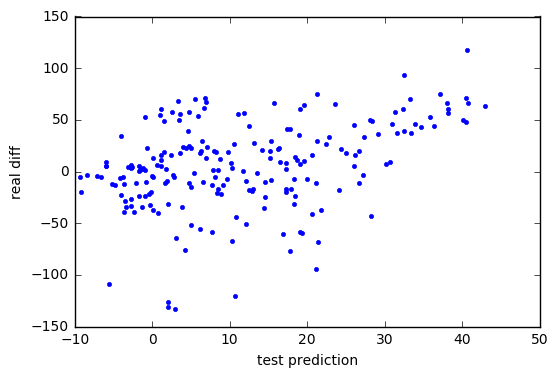

In [20]:
import numpy
plt.plot(pred, y_test, ".")
plt.ylabel('real diff')
plt.xlabel('test prediction')
print numpy.corrcoef(pred,y_test)

[[ 1.          0.99063007]
 [ 0.99063007  1.        ]]


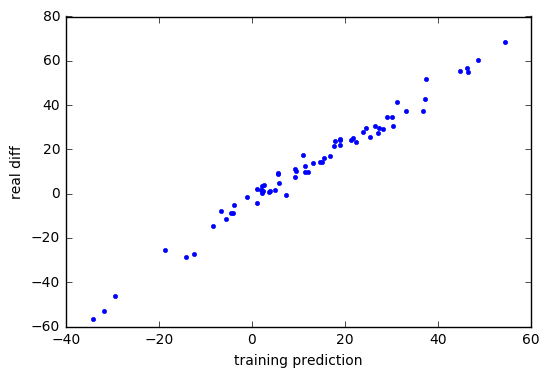

In [21]:
plt.plot(pred_train, y_train, ".")
plt.ylabel('real diff')
plt.xlabel('training prediction')
print numpy.corrcoef(pred_train,y_train)

In [25]:
regres.oob_prediction_

array([  6.712     ,  -2.23363636,  14.90142857,   1.2895122 ,
        -1.06275862,  -4.67285714,   2.86545455,  13.49888889,
        11.58526316,   2.87214286,  -3.15083333,   3.49452381,
        -8.15314286,   9.93128205,  -2.2315625 ,  -0.55147059,
        14.41388889,  -4.21388889,   5.45818182,   4.44565217,
        25.02853659,  19.04489362,   3.57595238,  25.26822222,
        26.05928571,  16.24394737,  -0.66871795,  -4.10677419,
        21.68842105,  21.62763158,  30.29977273,  -5.81394737,
         3.04795455,   6.88964286,   8.06296296,  11.24323529,
        29.84210526,  33.3335    ,  21.63631579,  24.90525   ,
        36.88325581,  32.31238095,  30.315     ,  28.04171429,
        18.74333333,  13.07105263,  12.40878049,   6.63766667,
         2.73323529,  -6.01625   ,  17.38923077,   1.19088235,
         9.17189189,   3.28578947,   3.46967742,   2.75375   ,
        10.5025    ,  14.2825641 ,  17.2103125 ,  26.92071429,
        24.17857143,  13.69511628,   4.45216216,  16.22

[[ 1.          0.80332236]
 [ 0.80332236  1.        ]]


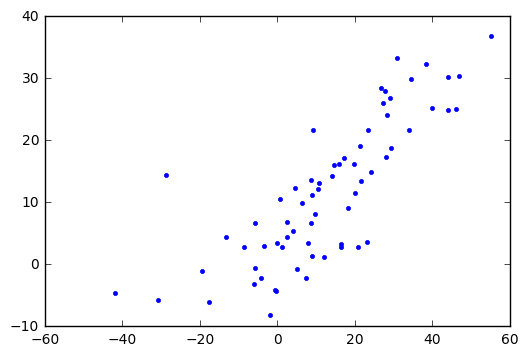

In [26]:
pred_train
plt.plot(pred_train, regres.oob_prediction_, ".")
print numpy.corrcoef(pred_train,regres.oob_prediction_)

### backtesting 
1. First add pred and y_test to numpy array x_test

In [89]:
##pred = np.reshape(pred, (209, 1))
test_res = np.c_[ X_test, pred, y_test] 

In [22]:
print X_test.shape
print pred.shape
print X_train.shape
print pred_train.shape

(209, 153)
(209,)
(67, 153)
(67,)


In [23]:
# get dictionary for ((today's date, settlement's date): prediction)
def createPredDict(row, pred_dict):
    if not pred_dict.has_key((row['todaydate'],row['settledate'])):
        pred_dict[(row['todaydate'],row['settledate'])] = row['pred']

def getPredict(df):
    """get predition for each today's date and settledate
    """
    prediction = {}
    df.apply(lambda row: createPredDict(row, prediction), axis=1)
    return prediction

predAll = numpy.append(pred_train,pred,axis=0)
df5['pred'] = predAll.tolist()
predDict = getPredict(df5)

In [24]:
mask3 = (within30data['settledate'] > datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
testdf= within30data.loc[mask3]

0     2013-12-03
1     2013-12-04
2     2014-02-19
3     2014-02-26
4     2014-03-12
5     2014-04-09
6     2014-05-15
7     2014-06-02
8     2014-06-03
9     2014-06-04
10    2014-06-11
11    2014-06-24
12    2014-06-25
13    2014-07-08
14    2014-07-22
15    2014-07-23
16    2014-07-25
17    2014-08-20
18    2014-08-27
19    2014-09-18
20    2014-10-20
21    2014-10-21
22    2014-10-22
23    2014-10-24
24    2014-11-14
25    2014-12-01
26    2014-12-02
27    2014-12-03
28    2015-01-05
29    2015-02-06
         ...    
246   2016-11-16
247   2016-11-28
248   2016-11-29
249   2016-11-30
250   2016-12-02
251   2016-12-05
252   2016-12-06
253   2016-12-07
254   2016-12-07
255   2016-12-09
256   2016-12-12
257   2016-12-13
258   2016-12-14
259   2016-12-19
260   2016-12-20
261   2016-12-28
262   2017-01-04
263   2017-01-10
264   2017-01-11
265   2017-01-12
266   2017-01-13
267   2017-01-17
268   2017-01-18
269   2017-02-01
270   2017-02-02
271   2017-02-06
272   2017-02-07
273   2017-02-

In [56]:
## add sp500 predction to each option

def getPred(row,pred_dict):
    if pred_dict.has_key((row['todaydate'],row['settledate'])):
        return pred_dict[(row['todaydate'],row['settledate'])]
    else:
        return 0

def changePred(df, pred_dict):
    pred0 = df.apply(lambda row: getPred(row, pred_dict), axis=1)
    df['pred'] = pred0
        
changePred(testdf, predDict)
    


/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
testdf.describe()

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,sp1d,...,vol1day,opint1day,closing1w,vol1w,opint1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,pred
count,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000,...,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000,11110.000000
mean,9.017822,2098.657160,2103.899805,2098.467147,16.855317,17.404239,16.170410,1945.583708,15043.739964,2080.851785,...,1526.544644,14677.343564,19.277484,1219.322052,13926.531953,1.123584,1.281037,1.039324,1.126144,5.159756
std,5.182044,106.839943,110.925118,107.648432,11.528847,11.871257,11.293851,4181.194989,16048.792766,212.273631,...,3446.508304,15957.837953,16.256319,2990.586335,15747.371079,0.300458,1.788618,0.137066,0.791920,10.499602
min,2.000000,1829.080000,1864.780000,1800.000000,0.100000,0.000000,0.000000,0.000000,5001.000000,0.000000,...,0.000000,5001.000000,0.125000,0.000000,5001.000000,0.491909,0.021718,0.491909,0.087121,-9.312800
25%,4.000000,2036.090000,2040.040000,2035.000000,7.450000,7.700000,6.900000,0.000000,6862.250000,2033.110000,...,0.000000,6587.000000,7.700000,0.000000,6247.000000,1.000000,0.671143,0.996964,0.766667,0.000000
50%,9.000000,2091.540000,2090.110000,2095.000000,14.800000,15.300000,14.200000,76.500000,9782.000000,2091.540000,...,45.500000,9350.000000,15.250000,33.000000,8496.000000,1.020588,1.000000,1.001935,1.000000,0.000000
75%,14.000000,2170.840000,2170.860000,2175.000000,24.387500,25.200000,23.500000,2093.000000,15527.000000,2170.060000,...,1497.000000,15017.750000,26.187500,1036.250000,13738.500000,1.152077,1.252945,1.048352,1.194938,5.953100
max,19.000000,2369.750000,2381.920000,2395.000000,87.200000,91.200000,83.200000,46046.000000,149669.000000,2369.750000,...,39238.000000,149669.000000,140.600000,36355.000000,147822.000000,5.587633,33.857143,4.399506,15.076923,42.953100


In [28]:
testdf['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 0:
        return 0
    else:
        if row.pred > 0:
            if row.optionstrike <= row.today_sp_price and row.optiontype == "put":
                if row.settle_sp_price >= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
        elif row.pred < 0:
            if row.optionstrike >= row.today_sp_price and row.optiontype == "call":
                if row.settle_sp_price <= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
        else:
            return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 100), axis=1)
    df['pl'] = pl0
            
    
getPl(testdf, predDict)
testdf['pl'].fillna(0, inplace=True)
    

/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
positivedf = testdf 
neagtivedf = testdf 
positivedf = testdf[testdf.pl > 0]
negativedf = testdf[testdf.pl < 0]
negativedf.describe()


,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,sp1d,...,opint1day,closing1w,vol1w,opint1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,pred,pl
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,...,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,5.454545,2076.485057,2025.270795,2065.625000,9.309659,9.789489,8.829830,3703.818182,15651.340909,2074.292216,...,15151.943182,15.379545,1977.761364,14323.403409,1.141261,0.931206,1.049569,1.039785,9.265155,-3645.227273
std,3.807989,79.231056,105.307167,86.600272,5.519544,5.673046,5.381846,5807.159851,15751.618796,81.762577,...,15290.053877,13.422216,2939.081108,15594.322563,0.262548,0.771692,0.143354,0.567260,9.006935,3179.738752
min,2.000000,1923.670000,1880.020000,1895.000000,0.225000,0.400000,0.050000,0.000000,5002.000000,1893.360000,...,5002.000000,0.250000,0.000000,5002.000000,0.768960,0.071429,0.810276,0.173529,-5.990500,-12161.000000
25%,3.000000,2063.590000,1970.890000,2050.000000,5.100000,5.400000,4.750000,215.250000,6260.250000,2062.365000,...,5873.250000,6.300000,2.000000,5833.000000,1.000000,0.385736,0.995016,0.614286,2.069850,-4539.000000
50%,4.000000,2080.410000,2012.370000,2070.000000,8.400000,8.900000,8.050000,1720.000000,9249.000000,2084.390000,...,8670.500000,11.225000,732.000000,7609.500000,1.037443,0.732558,1.002661,1.000000,7.668100,-2860.000000
75%,8.000000,2102.440000,2040.040000,2090.000000,12.900000,13.500000,12.100000,5050.000000,15802.250000,2102.440000,...,15676.750000,18.900000,2553.500000,13271.500000,1.190672,1.000000,1.076259,1.266234,19.117300,-1357.250000
max,17.000000,2294.670000,2347.220000,2320.000000,27.900000,28.500000,27.300000,43718.000000,80962.000000,2293.080000,...,69388.000000,66.500000,17227.000000,88517.000000,2.291132,3.938931,2.030769,2.718310,28.183400,-20.000000


In [30]:
positivedf.describe()

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,sp1d,...,opint1day,closing1w,vol1w,opint1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,pred,pl
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,...,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,8.364356,2093.186614,2109.850723,2084.559406,11.315446,11.847772,10.727475,3561.616832,21099.085149,2090.899733,...,20565.604950,19.517807,2061.535644,19654.965347,1.112905,1.111979,1.045253,0.979100,13.068816,1080.415842
std,5.214328,101.006777,98.268067,109.252025,8.342027,8.616349,8.131585,6503.982139,20548.776664,101.992048,...,20448.635777,18.555838,4361.504438,19840.677805,0.247988,2.401444,0.130310,0.612899,14.194870,813.171060
min,2.000000,1851.860000,1880.330000,1825.000000,0.225000,0.000000,0.000000,0.000000,5014.000000,1852.210000,...,5006.000000,0.175000,0.000000,5006.000000,0.516127,0.021718,0.516127,0.087121,-9.312800,9.000000
25%,3.000000,2015.930000,2049.580000,2000.000000,4.700000,5.000000,4.300000,0.000000,8076.000000,2014.890000,...,7469.000000,6.262500,0.000000,6998.000000,1.000000,0.372226,0.997709,0.653060,0.241925,454.000000
50%,8.000000,2086.590000,2089.640000,2075.000000,9.350000,10.000000,8.850000,543.500000,13415.500000,2089.140000,...,12796.000000,13.775000,105.000000,12115.000000,1.034488,0.799523,1.010123,0.898418,10.267500,860.000000
75%,13.000000,2173.600000,2170.060000,2185.000000,16.300000,17.075000,15.900000,4200.000000,24702.750000,2170.860000,...,24090.000000,25.925000,2271.000000,23215.500000,1.160479,1.011586,1.049321,1.068754,24.126900,1543.750000
max,18.000000,2328.250000,2347.220000,2325.000000,42.650000,45.300000,41.300000,46046.000000,128349.000000,2316.100000,...,126967.000000,101.050000,34800.000000,125910.000000,4.116423,31.555556,2.281036,4.575758,42.953100,4265.000000


In [31]:
print "profit is "+ str(positivedf['pl'].sum())
print "loss is " + str(negativedf['pl'].sum())

profit is 1091220.0
loss is -641560.0


,todaydate,settledate,daystosettle,today_sp_price,settle_sp_price,optiontype,optionstrike,optionclosingprice,optionhighprice,optionlowprice,...,opint1day,closing1w,vol1w,opint1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,pred,pl
39938,2015-06-15,2015-07-02,17,2084.43,2076.78,put,2070,21.650,22.10,21.20,...,6544,21.650,211,6544,1.000000,1.000000,1.000000,1.000000,0.0,0.0
39940,2015-06-15,2015-07-02,17,2084.43,2076.78,call,2100,16.650,17.10,16.20,...,12373,16.650,124,12373,1.000000,1.000000,1.000000,1.000000,0.0,0.0
39941,2015-06-15,2015-07-02,17,2084.43,2076.78,put,2100,34.100,35.00,33.20,...,8131,34.100,45,8131,1.000000,1.000000,1.000000,1.000000,0.0,0.0
39966,2015-06-16,2015-07-02,16,2096.29,2076.78,put,2070,15.950,16.20,15.70,...,6544,21.650,211,6544,1.010544,0.736721,1.010544,0.736721,0.0,0.0
39968,2015-06-16,2015-07-02,16,2096.29,2076.78,call,2100,22.400,22.80,22.00,...,12373,16.650,124,12373,1.053342,1.345345,1.053342,1.345345,0.0,0.0
39969,2015-06-16,2015-07-02,16,2096.29,2076.78,put,2100,26.050,26.60,25.50,...,8131,34.100,45,8131,1.183126,0.763930,1.183126,0.763930,0.0,0.0
39972,2015-06-16,2015-07-02,16,2096.29,2076.78,call,2125,10.150,10.40,9.90,...,5266,6.800,58,5266,1.002469,1.492647,1.002469,1.492647,0.0,0.0
39998,2015-06-17,2015-07-02,15,2100.44,2076.78,call,2100,21.200,21.50,20.90,...,13033,22.400,247,13033,1.001918,0.946429,1.001918,0.946429,0.0,0.0
39999,2015-06-17,2015-07-02,15,2100.44,2076.78,put,2100,24.600,25.00,24.20,...,9620,26.050,1285,9620,0.984200,0.944338,0.984200,0.944338,0.0,0.0
40002,2015-06-17,2015-07-02,15,2100.44,2076.78,call,2125,9.300,9.60,9.00,...,5279,10.150,2207,5279,1.400455,0.916256,1.400455,0.916256,0.0,0.0


# 7th week 

1. testdf is all the options that we are going to trade.
2. putdf are put options and calldf are call options
3. generate scatter points for put and call option where x axis is prediction and y is profit

In [38]:
interestedDf = testdf
interestedDf = testdf[testdf.pl!=0]
putDf = interestedDf[interestedDf.optiontype == 'put']
callDf = interestedDf[interestedDf.optiontype == 'call']

In [39]:
putDf.describe()

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,sp1d,...,opint1day,closing1w,vol1w,opint1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,pred,pl
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,...,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,8.141304,2060.481967,2071.601283,2044.608696,12.721277,13.296196,12.085272,4465.767391,19645.646739,2058.410554,...,19024.697826,22.344440,2544.205435,17981.603261,1.125203,0.918076,1.050496,0.989437,17.068494,394.717935
std,5.141907,87.172041,98.810058,87.435094,8.051752,8.325679,7.862302,6893.354501,19632.321657,88.839397,...,19378.007551,18.844007,4573.118785,18656.495254,0.252799,0.845651,0.135727,0.646852,12.017144,2469.215502
min,2.000000,1851.860000,1880.020000,1825.000000,0.425000,0.000000,0.000000,0.000000,5002.000000,1852.210000,...,5002.000000,1.175000,0.000000,5002.000000,0.516127,0.021718,0.516127,0.087121,0.076500,-12161.000000
25%,3.000000,1994.240000,2023.040000,1980.000000,6.300000,6.700000,5.900000,85.250000,7252.000000,1989.260000,...,6882.000000,9.687500,0.000000,6426.500000,1.000000,0.371843,1.000000,0.614286,6.809500,333.750000
50%,8.000000,2075.000000,2070.770000,2050.000000,11.350000,11.950000,10.800000,2035.500000,12343.000000,2075.000000,...,11603.000000,17.050000,545.000000,10899.000000,1.037761,0.822592,1.011234,0.897297,15.284000,857.500000
75%,11.000000,2099.200000,2091.690000,2080.000000,17.862500,18.525000,17.100000,5801.750000,23307.000000,2099.200000,...,23127.750000,28.600000,3028.000000,20048.000000,1.167559,1.015068,1.059316,1.068905,26.177100,1626.250000
max,18.000000,2328.250000,2347.220000,2325.000000,42.650000,45.300000,41.300000,46046.000000,128349.000000,2316.100000,...,126967.000000,101.050000,34800.000000,125910.000000,4.116423,5.714286,2.281036,4.575758,42.953100,4265.000000


In [40]:
callDf.describe()

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,sp1d,...,opint1day,closing1w,vol1w,opint1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,pred,pl
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,...,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,7.210526,2195.249774,2186.179361,2210.206767,5.126034,5.476316,4.775752,528.567669,22521.492481,2192.279887,...,22313.086466,7.003383,336.721805,21914.883459,1.089135,1.663013,1.029975,0.983500,-3.281366,325.261278
std,5.052259,51.523567,63.690428,52.323869,4.196772,4.280987,4.117593,2547.010755,21102.232649,53.420817,...,21270.306341,4.996746,1348.288275,21363.790089,0.239775,4.411067,0.118421,0.440233,2.386727,823.098974
min,2.000000,2075.150000,1970.890000,2080.000000,0.225000,0.300000,0.050000,0.000000,5022.000000,2052.510000,...,5059.000000,0.175000,0.000000,5059.000000,0.633631,0.053922,0.746204,0.090278,-9.312800,-3882.000000
25%,3.000000,2169.180000,2147.260000,2185.000000,1.675000,2.012500,1.462500,0.000000,9287.750000,2168.270000,...,9116.000000,3.300000,0.000000,7642.250000,0.986287,0.390553,0.986434,0.681856,-4.215700,131.875000
50%,7.000000,2181.310000,2187.020000,2197.500000,4.000000,4.350000,3.600000,0.000000,14823.500000,2181.310000,...,14053.000000,6.050000,0.000000,13480.000000,1.028312,0.729529,1.003654,0.970577,-2.732500,360.000000
75%,10.000000,2256.960000,2249.260000,2263.750000,7.787500,8.100000,7.500000,0.000000,25737.000000,2256.960000,...,25631.500000,10.037500,0.000000,26534.750000,1.145062,1.000000,1.039290,1.121680,-1.312500,710.000000
max,18.000000,2294.670000,2347.220000,2320.000000,20.450000,20.700000,20.200000,31927.000000,116583.000000,2293.080000,...,117620.000000,27.400000,10307.000000,106058.000000,2.668098,31.555556,1.828594,2.489796,-0.080600,2045.000000


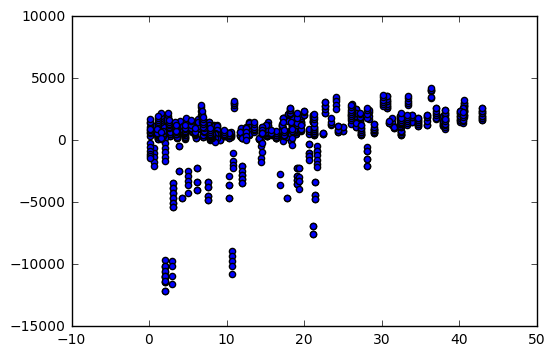

In [51]:
plt.scatter(putDf['pred'], putDf['pl'])

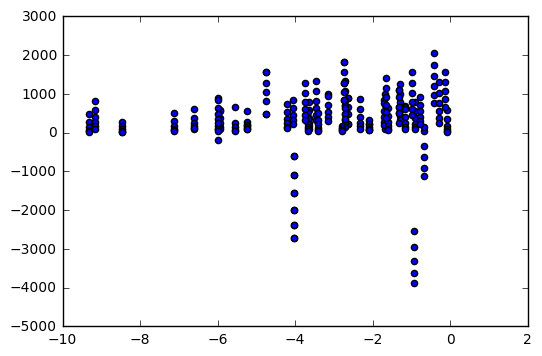

In [55]:
plt.scatter(callDf['pred'], callDf['pl'])

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,sp1d,...,opint1day,closing1w,vol1w,opint1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,pred,pl
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,...,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,8.141304,2060.481967,2071.601283,2044.608696,12.721277,13.296196,12.085272,4465.767391,19645.646739,2058.410554,...,19024.697826,22.344440,2544.205435,17981.603261,1.125203,0.918076,1.050496,0.989437,17.068494,394.717935
std,5.141907,87.172041,98.810058,87.435094,8.051752,8.325679,7.862302,6893.354501,19632.321657,88.839397,...,19378.007551,18.844007,4573.118785,18656.495254,0.252799,0.845651,0.135727,0.646852,12.017144,2469.215502
min,2.000000,1851.860000,1880.020000,1825.000000,0.425000,0.000000,0.000000,0.000000,5002.000000,1852.210000,...,5002.000000,1.175000,0.000000,5002.000000,0.516127,0.021718,0.516127,0.087121,0.076500,-12161.000000
25%,3.000000,1994.240000,2023.040000,1980.000000,6.300000,6.700000,5.900000,85.250000,7252.000000,1989.260000,...,6882.000000,9.687500,0.000000,6426.500000,1.000000,0.371843,1.000000,0.614286,6.809500,333.750000
50%,8.000000,2075.000000,2070.770000,2050.000000,11.350000,11.950000,10.800000,2035.500000,12343.000000,2075.000000,...,11603.000000,17.050000,545.000000,10899.000000,1.037761,0.822592,1.011234,0.897297,15.284000,857.500000
75%,11.000000,2099.200000,2091.690000,2080.000000,17.862500,18.525000,17.100000,5801.750000,23307.000000,2099.200000,...,23127.750000,28.600000,3028.000000,20048.000000,1.167559,1.015068,1.059316,1.068905,26.177100,1626.250000
max,18.000000,2328.250000,2347.220000,2325.000000,42.650000,45.300000,41.300000,46046.000000,128349.000000,2316.100000,...,126967.000000,101.050000,34800.000000,125910.000000,4.116423,5.714286,2.281036,4.575758,42.953100,4265.000000


In [ ]:
## more restricted trade 

In [57]:
testdf2 = testdf
testdf2['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 0:
        return 0
    else:
        if row.pred > 0:
            if row.optionstrike <= row.today_sp_price - row.pred and row.optiontype == "put":
                if row.settle_sp_price >= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
        elif row.pred < 0:
            if row.optionstrike >= row.today_sp_price  - row.pred and row.optiontype == "call":
                if row.settle_sp_price <= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
        else:
            return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 100), axis=1)
    df['pl'] = pl0
            
    
getPl(testdf2, predDict)
testdf2['pl'].fillna(0, inplace=True)
    

/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mengranwang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [59]:
positivedf2 = testdf2 
neagtivedf2 = testdf2 
positivedf2 = testdf2[testdf2.pl > 0]
negativedf2 = testdf2[testdf2.pl < 0]
negativedf2.describe()

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,sp1d,...,opint1day,closing1w,vol1w,opint1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,pred,pl
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,...,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,5.216981,2103.556038,2051.527264,2090.801887,6.638679,7.014623,6.262736,2898.745283,15678.688679,2101.560472,...,15243.094340,11.942925,1528.235849,13708.877358,1.152895,0.799108,1.050978,1.071527,4.913173,-4030.537736
std,3.171314,72.903523,111.586122,85.219986,4.136841,4.254230,4.026230,3735.166423,14464.478604,73.307884,...,14331.160998,10.319849,2078.003999,12619.592624,0.239312,0.572290,0.157833,0.558015,6.753560,3707.045806
min,2.000000,1923.670000,1880.020000,1895.000000,0.225000,0.400000,0.050000,0.000000,5002.000000,1893.360000,...,5002.000000,0.250000,0.000000,5002.000000,0.768960,0.071429,0.810276,0.173529,-4.018200,-12161.000000
25%,3.000000,2077.070000,1970.890000,2060.000000,3.812500,4.150000,3.425000,13.000000,6337.250000,2078.580000,...,5720.000000,5.187500,0.250000,5555.000000,1.000000,0.363859,0.999166,0.630713,0.695000,-4657.750000
50%,4.000000,2096.920000,2023.040000,2075.000000,6.075000,6.450000,5.700000,1586.500000,9934.500000,2091.690000,...,9342.500000,9.150000,707.500000,7999.000000,1.063784,0.638554,1.007721,1.000000,2.943400,-2798.000000
75%,7.000000,2115.480000,2077.990000,2100.000000,8.512500,8.875000,8.175000,4291.250000,17205.000000,2109.840000,...,15888.000000,15.312500,2154.000000,14686.750000,1.242873,1.000000,1.076259,1.357170,7.668100,-1293.500000
max,17.000000,2294.670000,2347.220000,2320.000000,22.450000,23.200000,21.700000,21777.000000,70024.000000,2293.080000,...,62963.000000,55.600000,8735.000000,60293.000000,2.030769,2.694915,2.030769,2.718310,28.183400,-48.000000


In [60]:
positivedf2.describe()

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,sp1d,...,opint1day,closing1w,vol1w,opint1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,pred,pl
count,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.00000,581.000000,581.000000,581.000000,...,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000
mean,7.624785,2139.115336,2145.292513,2132.383821,7.137771,7.508864,6.69759,2355.851979,21465.846816,2136.475921,...,20958.829604,13.531730,1199.507745,20148.542169,1.113275,1.185809,1.050449,0.948853,4.601667,695.143718
std,5.295770,88.685433,94.937682,99.825049,5.420801,5.558230,5.34814,5419.527617,21040.552592,89.515065,...,21064.990487,14.384522,3137.668309,20429.765616,0.270278,2.947827,0.154059,0.596219,8.005176,529.208622
min,2.000000,1890.280000,1880.330000,1865.000000,0.225000,0.000000,0.00000,0.000000,5014.000000,1895.580000,...,5014.000000,0.175000,0.000000,5014.000000,0.633631,0.021718,0.746204,0.087121,-9.312800,22.500000
25%,3.000000,2083.370000,2079.360000,2060.000000,2.950000,3.200000,2.50000,0.000000,7713.000000,2084.390000,...,7090.000000,4.150000,0.000000,6725.000000,1.000000,0.347368,0.996223,0.620370,-1.648600,285.000000
50%,7.000000,2163.260000,2147.260000,2150.000000,5.700000,6.100000,5.30000,0.000000,13890.000000,2160.770000,...,12979.000000,9.950000,0.000000,12277.000000,1.034811,0.760479,1.006698,0.891304,2.753600,555.000000
75%,11.000000,2186.160000,2187.120000,2200.000000,10.250000,10.800000,9.80000,2631.000000,25457.000000,2186.160000,...,25261.000000,16.300000,886.000000,24590.000000,1.160249,1.000000,1.045039,1.053191,9.178600,995.000000
max,18.000000,2328.250000,2347.220000,2325.000000,33.450000,34.600000,32.30000,43429.000000,128349.000000,2316.100000,...,126967.000000,85.550000,34800.000000,125910.000000,4.116423,31.555556,2.281036,4.575758,26.709300,3345.000000


In [62]:
print "profit is "+ str(positivedf2['pl'].sum())
print "loss is " + str(negativedf2['pl'].sum())

profit is 403878.5
loss is -427237.0


In [63]:
interestedDf2 = testdf2
interestedDf2 = testdf2[testdf2.pl!=0]
putDf2 = interestedDf2[interestedDf2.optiontype == 'put']
callDf2 = interestedDf2[interestedDf2.optiontype == 'call']

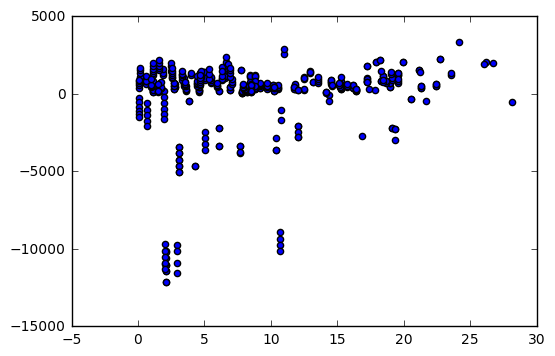

In [64]:
plt.scatter(putDf2['pred'], putDf2['pl'])

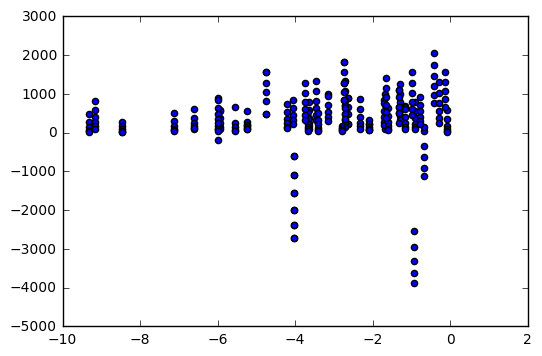

In [65]:
plt.scatter(callDf['pred'], callDf['pl'])